In [1]:
import numpy as np
import torch 
import torch.nn as nn
import math 
import h5py
import yaml
import pickle
import sys
import os
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

current_dir = os.path.abspath(os.getcwd())
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)


import src.models as models
import src.dataset as ds
import src.train_pcdae as train_pcdae
import src.inference_pcdae as inference
import src.data_preparation as data_prep

In [2]:

with h5py.File("scaling_noise_level_pcdae_sine_Vnew.h5", "r") as f:
    
    seed_vec_pcdae = f['results/seed'][:]
    sigma_vec_pcdae = f['results/sigma_max'][:]
    loss_init_pcdae = f['results/loss_init'][:]
    loss_refine1_pcdae = f['results/loss_refine1'][:]
    loss_refine2_pcdae = f['results/loss_refine2'][:]
    pickled_config = f['results/config'][()]

config_pcdae = pickle.loads(pickled_config)


unique_sigma = np.unique(sigma_vec_pcdae)
loss_refine1_dict = {ele: [] for ele in unique_sigma}
loss_refine2_dict = {ele: [] for ele in unique_sigma}

for i in range(len(seed_vec_pcdae)):
    
    loss_refine1_dict[sigma_vec_pcdae[i]].append(loss_refine1_pcdae[i])
    loss_refine2_dict[sigma_vec_pcdae[i]].append(loss_refine2_pcdae[i])


mean_refine1_plot = []
mean_refine2_plot = []
std_refine1_plot = []
std_refine2_plot = []

for i, (size, vec) in enumerate(loss_refine1_dict.items()):
    vec_sqrt = np.sqrt(vec)
    mean_refine1_plot.append(np.mean(vec_sqrt))
    std_refine1_plot.append(np.std(vec_sqrt))

for i, (size, vec) in enumerate(loss_refine2_dict.items()):
    vec_sqrt = np.sqrt(vec)
    mean_refine2_plot.append(np.mean(vec_sqrt))
    std_refine2_plot.append(np.std(vec_sqrt))


mean_refine1_plot = np.array(mean_refine1_plot)
mean_refine2_plot = np.array(mean_refine2_plot)
std_refine1_plot = np.array(std_refine1_plot)
std_refine2_plot = np.array(std_refine2_plot)


In [3]:
print(mean_refine1_plot)
print(std_refine1_plot)

print(mean_refine2_plot)
print(std_refine2_plot)

[0.0793156  0.03615339 0.03127571 0.03101275 0.02991066 0.03015954
 0.02982471]
[0.03380144 0.0184159  0.01325093 0.0157452  0.01482319 0.01392008
 0.01199403]
[0.07967059 0.0360805  0.03117068 0.03092568 0.02991876 0.03014577
 0.02981157]
[0.03388085 0.01843951 0.01336342 0.01576023 0.01481797 0.01391301
 0.01199272]


In [4]:

with h5py.File("scaling_noise_level_ebm_pcdae_sine_0.05_Vnew.h5", "r") as f:
    
    seed_vec_pcdae = f['results/seed'][:]
    sigma_vec_pcdae = f['results/sigma_max'][:]
    loss_init_ebm_pcdae = f['results/loss_init'][:]
    loss_refine1_ebm_pcdae = f['results/loss_refine1'][:]
    pickled_config = f['results/config'][()]

config_pcdae = pickle.loads(pickled_config)


unique_sigma = np.unique(sigma_vec_pcdae)
loss_refine1_ebm_dict = {ele: [] for ele in unique_sigma}

for i in range(len(seed_vec_pcdae)):
    
    loss_refine1_ebm_dict[sigma_vec_pcdae[i]].append(loss_refine1_ebm_pcdae[i])


mean_refine1_ebm_plot = []
std_refine1_ebm_plot = []

for i, (size, vec) in enumerate(loss_refine1_ebm_dict.items()):
    vec_sqrt = np.sqrt(vec)
    mean_refine1_ebm_plot.append(np.mean(vec_sqrt))
    std_refine1_ebm_plot.append(np.std(vec_sqrt))

mean_refine1_ebm_plot = np.array(mean_refine1_ebm_plot)
std_refine1_ebm_plot = np.array(std_refine1_ebm_plot)


In [5]:
print(mean_refine1_ebm_plot)
print(std_refine1_ebm_plot)

[0.08493474 0.03671812 0.03182849 0.03365003 0.03443355 0.03173014
 0.03267749]
[0.03418831 0.01976348 0.01141518 0.01779661 0.01744362 0.01216716
 0.01356353]


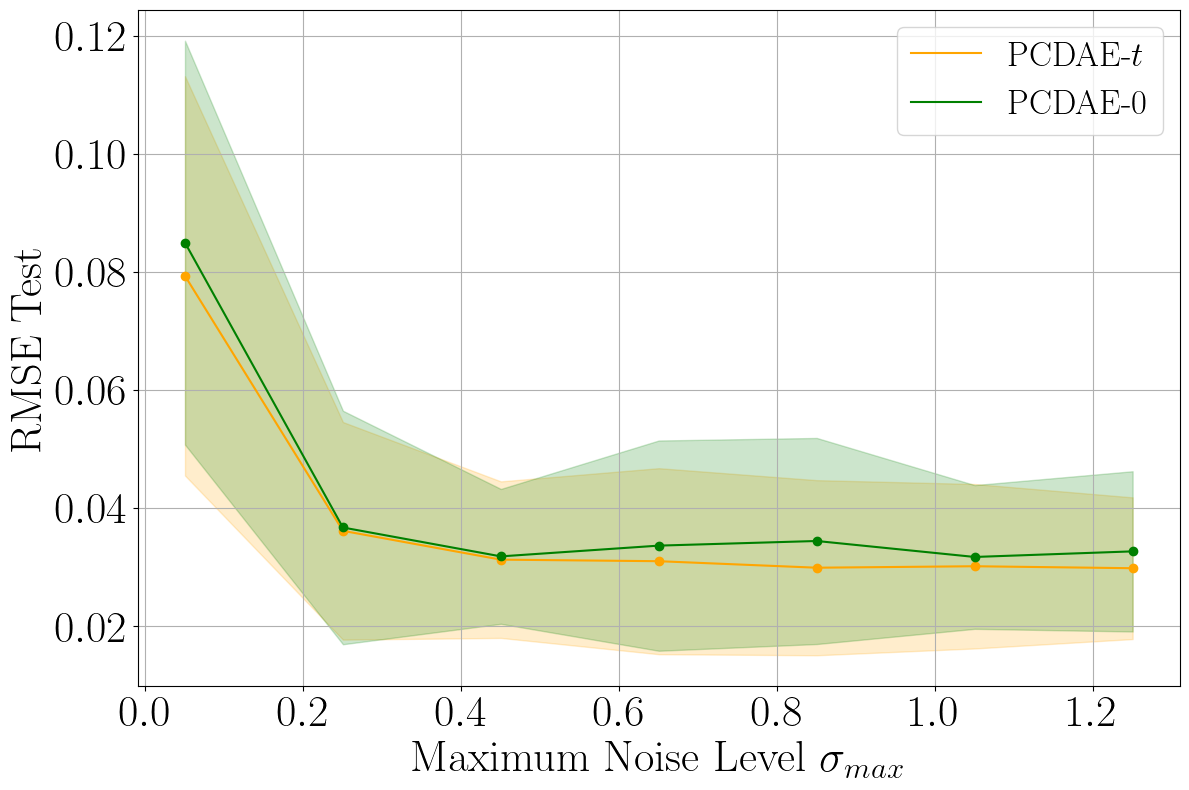

In [10]:

fig, ax = plt.subplots(figsize=(12, 8))
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'

plt.plot(unique_sigma, mean_refine1_plot, color="orange", label=r"PCDAE-$t$")
plt.plot(unique_sigma, mean_refine1_plot, 'o', color="orange")
plt.fill_between(unique_sigma,
                    mean_refine1_plot - std_refine1_plot,
                    mean_refine1_plot + std_refine1_plot,
                    alpha=0.2, color="orange")

plt.plot(unique_sigma, mean_refine1_ebm_plot, color="green", label=r"PCDAE-$0$")
plt.plot(unique_sigma, mean_refine1_ebm_plot, 'o', color="green")
plt.fill_between(unique_sigma,
                    mean_refine1_ebm_plot - std_refine1_ebm_plot,
                    mean_refine1_ebm_plot + std_refine1_ebm_plot,
                    alpha=0.2, color="green")


plt.xlabel(r'Maximum Noise Level $\sigma_{max}$', fontsize=32)
plt.ylabel(r'RMSE Test', fontsize=32)
# plt.ylabel(r'$T/\Lambda$', fontsize=32)
ax.tick_params(axis='x', labelsize=32)
ax.tick_params(axis='y', labelsize=32)
plt.legend(fontsize=25)
# plt.ylim(0.005, 0.09)
plt.tight_layout()
plt.grid()
plt.savefig("scaling_sigma_max_Vnew2.png")